In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/train.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev5/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev5/val.feather')

In [5]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_feather(f'{TRAIN_PATH}')
test      = pd.read_feather(f'{TEST_PATH}')

CPU times: user 244 ms, sys: 137 ms, total: 381 ms
Wall time: 380 ms


In [6]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

## Feature Engineering

In [7]:
traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]


FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections'
           ]

X_trn = traintest.iloc[:ntrain][FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click']

X_val = traintest.iloc[ntrain:][FEATURES]
y_val = traintest.iloc[ntrain:]['is_click']

print('Train nulls:\n{}'.format(X_trn.isnull().sum()))
print('\nTest nulls:\n{}'.format(X_val.isnull().sum()))

Train nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
dtype: int64

Test nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
dtype: int64


** Train and validate **

In [35]:
m = RandomForestClassifier(n_estimators=20, max_depth=13, min_samples_leaf=3, random_state=SEED, n_jobs=3)
m.fit(X_trn, y_trn)
val_preds = m.predict_proba(X_val)[:, 1]
print('AUC score: {}'.format(roc_auc_score(y_val, val_preds)))

AUC score: 0.5269933911448598


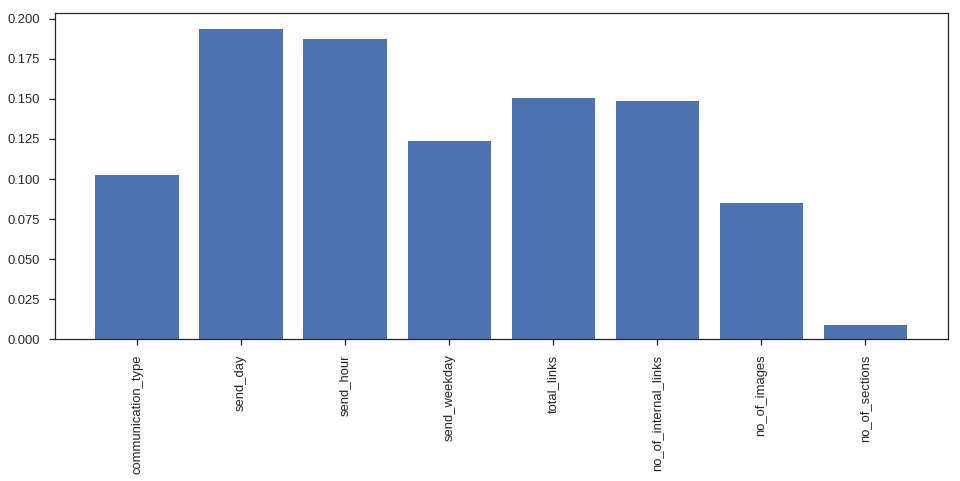

In [27]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(FEATURES)), m.feature_importances_)
plt.xticks(np.arange(len(FEATURES)), FEATURES, rotation=90);

In [28]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': .01,
    'max_depth': 2,
    'gamma': 1,
    'seed': SEED,
    'nthread': 4
}

dtrain = xgb.DMatrix(X_trn, y_trn, feature_names=FEATURES)
deval  = xgb.DMatrix(X_val, y_val, feature_names=FEATURES)

watchlist = [(dtrain, 'train'), (deval, 'eval')]

num_boost_round = 1000
early_stopping_rounds = 100

m = xgb.train(params, 
              dtrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              evals=watchlist, 
              verbose_eval=20)

[0]	train-auc:0.559383	eval-auc:0.539049
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[20]	train-auc:0.559383	eval-auc:0.539049
[40]	train-auc:0.559383	eval-auc:0.539049
[60]	train-auc:0.559383	eval-auc:0.539049
[80]	train-auc:0.559383	eval-auc:0.539049
[100]	train-auc:0.559383	eval-auc:0.539049
Stopping. Best iteration:
[0]	train-auc:0.559383	eval-auc:0.539049



In [29]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 10,
    'num_leaves': 16,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.597128	eval's auc: 0.526977
[40]	train's auc: 0.598593	eval's auc: 0.526977
[60]	train's auc: 0.599733	eval's auc: 0.526977
[80]	train's auc: 0.599815	eval's auc: 0.526977
[100]	train's auc: 0.599858	eval's auc: 0.526977
Early stopping, best iteration is:
[1]	train's auc: 0.596748	eval's auc: 0.53925


** Full Training **

In [8]:
%%time

m = RandomForestClassifier(n_estimators=20, max_depth=13, min_samples_leaf=3, random_state=SEED, n_jobs=3)
m.fit(X_trn, y_trn)
preds = m.predict_proba(X_val)[:, 1]

CPU times: user 28.7 s, sys: 223 ms, total: 28.9 s
Wall time: 10.3 s


** Generate Submissions **

In [9]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission7.csv', index=False)